# Importing libraries

In [ ]:
#Import libraries

import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional, Dropout, Input, Concatenate
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

from keras.models import Model
from keras.optimizers import Adam

nltk.download("stopwords")
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
#Load data with emotion scores

cleaned_dataset = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS78MfVeDvHIejQUnibyImcLWQi9GP3223sifwwQQxMNl6KNoZc8u651hAe-ILtm6-6mhQj7l6l282Z/pub?gid=452646790&single=true&output=csv'

In [ ]:
df = pd.read_csv(cleaned_dataset)
df.head(5)

,post,subreddit,joy,positive,anticipation,anger,disgust,negative,fear,sadness,trust,surprise
0,medication help hobby jump curious help stick ...,ADHD,0.294118,0.294118,0.235294,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000
1,still depress lazy year long depressive episod...,Depression,0.064516,0.193548,0.096774,0.064516,0.032258,0.290323,0.096774,0.096774,0.064516,0.000000
2,something use get thing really bad executive d...,ADHD,0.076923,0.115385,0.115385,0.153846,0.038462,0.115385,0.192308,0.076923,0.076923,0.038462
3,dae pick lip point raw bleeding cw blood lippi...,BPD,0.000000,0.142857,0.038961,0.103896,0.116883,0.246753,0.129870,0.142857,0.051948,0.025974
4,not actually use brain like try remember somet...,ADHD,0.105263,0.157895,0.105263,0.105263,0.105263,0.105263,0.052632,0.105263,0.105263,0.052632


In [ ]:
df = pd.read_csv(cleaned_dataset)
df.head(5)

,post,subreddit,joy,positive,anticipation,anger,disgust,negative,fear,sadness,trust,surprise
0,medication help hobby jump curious help stick ...,ADHD,0.294118,0.294118,0.235294,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000
1,still depress lazy year long depressive episod...,Depression,0.064516,0.193548,0.096774,0.064516,0.032258,0.290323,0.096774,0.096774,0.064516,0.000000
2,something use get thing really bad executive d...,ADHD,0.076923,0.115385,0.115385,0.153846,0.038462,0.115385,0.192308,0.076923,0.076923,0.038462
3,dae pick lip point raw bleeding cw blood lippi...,BPD,0.000000,0.142857,0.038961,0.103896,0.116883,0.246753,0.129870,0.142857,0.051948,0.025974
4,not actually use brain like try remember somet...,ADHD,0.105263,0.157895,0.105263,0.105263,0.105263,0.105263,0.052632,0.105263,0.105263,0.052632


In [ ]:
print(df.shape)

(77478, 12)


In [ ]:

df.subreddit.value_counts()

ADHD          24554
Depression    19021
Anxiety       11882
BPD            9773
Autism         7510
Bipolar        4738
Name: subreddit, dtype: int64

In [ ]:
#print the number of null values in each column
df.isnull().sum()

post            0
subreddit       0
joy             0
positive        0
anticipation    0
anger           0
disgust         0
negative        0
fear            0
sadness         0
trust           0
surprise        0
dtype: int64

**Feature Extraction**

In [ ]:
#Feature Interaction for the numerical features
import itertools

df_num= df.drop(['post', 'subreddit'], axis=1)
df_text= df['post']
df_label= df['subreddit']

cols = [col for col in df_num.columns]
cols = [col for col in cols if col != 'subreddit']
interactions = list(itertools.combinations(cols, 2))

for first_feat, second_feat in interactions:
    df_num[f'{first_feat}_plus_{second_feat}'] = df_num[f'{first_feat}'] + df_num[f'{second_feat}']

df_num.head()

,joy,positive,anticipation,anger,disgust,negative,fear,sadness,trust,surprise,...,negative_plus_fear,negative_plus_sadness,negative_plus_trust,negative_plus_surprise,fear_plus_sadness,fear_plus_trust,fear_plus_surprise,sadness_plus_trust,sadness_plus_surprise,trust_plus_surprise
0,0.294118,0.294118,0.235294,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.064516,0.193548,0.096774,0.064516,0.032258,0.290323,0.096774,0.096774,0.064516,0.000000,...,0.387097,0.387097,0.354839,0.290323,0.193548,0.161290,0.096774,0.161290,0.096774,0.064516
2,0.076923,0.115385,0.115385,0.153846,0.038462,0.115385,0.192308,0.076923,0.076923,0.038462,...,0.307692,0.192308,0.192308,0.153846,0.269231,0.269231,0.230769,0.153846,0.115385,0.115385
3,0.000000,0.142857,0.038961,0.103896,0.116883,0.246753,0.129870,0.142857,0.051948,0.025974,...,0.376623,0.389610,0.298701,0.272727,0.272727,0.181818,0.155844,0.194805,0.168831,0.077922
4,0.105263,0.157895,0.105263,0.105263,0.105263,0.105263,0.052632,0.105263,0.105263,0.052632,...,0.157895,0.210526,0.210526,0.157895,0.157895,0.157895,0.105263,0.210526,0.157895,0.157895


In [ ]:
data = pd.concat([df_text, df_label, df_num], axis=1)
data.head(5)

,post,subreddit,joy,positive,anticipation,anger,disgust,negative,fear,sadness,...,negative_plus_fear,negative_plus_sadness,negative_plus_trust,negative_plus_surprise,fear_plus_sadness,fear_plus_trust,fear_plus_surprise,sadness_plus_trust,sadness_plus_surprise,trust_plus_surprise
0,medication help hobby jump curious help stick ...,ADHD,0.294118,0.294118,0.235294,0.058824,0.058824,0.058824,0.000000,0.000000,...,0.058824,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,still depress lazy year long depressive episod...,Depression,0.064516,0.193548,0.096774,0.064516,0.032258,0.290323,0.096774,0.096774,...,0.387097,0.387097,0.354839,0.290323,0.193548,0.161290,0.096774,0.161290,0.096774,0.064516
2,something use get thing really bad executive d...,ADHD,0.076923,0.115385,0.115385,0.153846,0.038462,0.115385,0.192308,0.076923,...,0.307692,0.192308,0.192308,0.153846,0.269231,0.269231,0.230769,0.153846,0.115385,0.115385
3,dae pick lip point raw bleeding cw blood lippi...,BPD,0.000000,0.142857,0.038961,0.103896,0.116883,0.246753,0.129870,0.142857,...,0.376623,0.389610,0.298701,0.272727,0.272727,0.181818,0.155844,0.194805,0.168831,0.077922
4,not actually use brain like try remember somet...,ADHD,0.105263,0.157895,0.105263,0.105263,0.105263,0.105263,0.052632,0.105263,...,0.157895,0.210526,0.210526,0.157895,0.157895,0.157895,0.105263,0.210526,0.157895,0.157895


In [ ]:
# Split the DataFrame into three parts
split_ratio = [0.6, 0.2, 0.2]  # Ratios for the splits
split_indices = [0, round(len(data) * split_ratio[0]), round(len(data) * (split_ratio[0] + split_ratio[1]))]

df_train = df.iloc[split_indices[0]:split_indices[1]]
df_test = df.iloc[split_indices[1]:split_indices[2]]
df_val = df.iloc[split_indices[2]:]


# Deep Learning Model Training
Word embedding using this glove and use a sequance model

**Text Preprocessing**

In [ ]:
#Splitting the text from the labels
X_text_train = df_train['post']
X_num_train = df_train.drop(['post', 'subreddit'], axis=1)
y_train = df_train['subreddit']

X_text_test = df_test['post']
X_num_test = df_test.drop(['post', 'subreddit'], axis=1)
y_test = df_test['subreddit']

X_text_val = df_val['post']
X_num_val = df_val.drop(['post', 'subreddit'], axis=1)
y_val = df_val['subreddit']

In [ ]:
# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

#print the labels after encoding
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [ ]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]]


**Tokenizing**

In [ ]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_text_train, X_text_test], axis=0))

In [ ]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

61982

In [ ]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_text_train[1].split())

In [ ]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_text_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_text_train[1].split()).shape

(77, 68009)

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_text_train)
sequences_test = tokenizer.texts_to_sequences(X_text_test)
sequences_val = tokenizer.texts_to_sequences(X_text_val)

**Padding**

The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len.

In [ ]:
df.shape

(77478, 12)

In [ ]:
maxlen = max([len(t) for t in df['post']])
maxlen

3086

In [ ]:
X_text_train = pad_sequences(sequences_train, maxlen=512, truncating='pre')
X_text_test = pad_sequences(sequences_test, maxlen=512, truncating='pre')
X_text_val = pad_sequences(sequences_val, maxlen=512, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 68009


In [ ]:
#before
sequences_train[0]

In [ ]:
#after
X_text_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## Word Embedding

**This code defines the following variables:**

**path_to_glove_file**: The file path to the GloVe word vectors file.

**num_tokens**: The size of the vocabulary. This is typically the number of unique words in the dataset.

**embedding_dim**: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

**hits**: A counter for the number of words that are found in the embeddings_index dictionary.

**misses**: A counter for the number of words that are not found in the embeddings_index dictionary.

**embeddings_index**: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [ ]:
# Read GloVE embeddings

path_to_glove_file = '/content/drive/MyDrive/Colab Notebooks/Main Dissertation/glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

In [ ]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400001 word vectors.
Converted 30752 words (37256 misses)


# **Modeling with Text Features**




**GRU Model**

In [ ]:
# GRU Model
from keras.layers import Embedding, GRU, LSTM, Dense

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 300, input_length=X_text_train.shape[1], weights=[embedding_matrix], trainable=False))

# Using GRU layers
model.add(GRU(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 300)          20402700  
                                                                 
 gru (GRU)                   (None, 512, 256)          428544    
                                                                 
 gru_1 (GRU)                 (None, 512, 128)          148224    
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 21,017,106
Trainable params: 614,406
Non-trainable params: 20,402,700
_________________________________________________________________


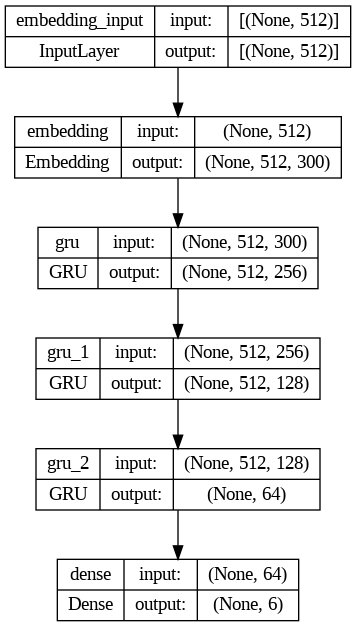

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_text_train,
                    y_train,
                    validation_data=(X_text_val, y_val),
                    verbose=1,
                    batch_size=64,
                    epochs=5,
                    callbacks=[callback]
                   )

Epoch 1/5
727/727 [==============================] - 2762s 4s/step - loss: 0.6674 - accuracy: 0.7791 - val_loss: 0.5188 - val_accuracy: 0.8288
Epoch 2/5
727/727 [==============================] - 2746s 4s/step - loss: 0.5158 - accuracy: 0.8326 - val_loss: 0.5283 - val_accuracy: 0.8281
Epoch 3/5
727/727 [==============================] - 2748s 4s/step - loss: 0.5468 - accuracy: 0.8203 - val_loss: 0.5349 - val_accuracy: 0.8271
Epoch 4/5
727/727 [==============================] - 2772s 4s/step - loss: 0.5260 - accuracy: 0.8255 - val_loss: 0.5124 - val_accuracy: 0.8314
Epoch 5/5
727/727 [==============================] - 2837s 4s/step - loss: 0.5220 - accuracy: 0.8292 - val_loss: 0.5208 - val_accuracy: 0.8314


In [ ]:
#print the overall loss and accuracy
model.evaluate(X_text_test, y_test, verbose=1)

485/485 [==============================] - 191s 395ms/step - loss: 0.5420 - accuracy: 0.8232


[0.5419528484344482, 0.8232333064079285]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have trained your model and have predictions
y_pred = model.predict(X_text_test)

# Assuming y_val and y_pred are in one-hot encoded format
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_test.argmax(axis=-1)

# Calculate overall precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-score:", f1)


485/485 [==============================] - 190s 390ms/step
Overall Precision: 0.8302590998554544
Overall Recall: 0.8232333010648596
Overall F1-score: 0.8230701275171151


In [ ]:
predicted = model.predict(X_text_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['subreddit']), y_pred))


485/485 [==============================] - 190s 391ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      4806
           1       0.77      0.82      0.80      2382
           2       0.85      0.78      0.81      1687
           3       0.87      0.67      0.76      2143
           4       0.76      0.71      0.73       805
           5       0.74      0.88      0.80      3672

    accuracy                           0.82     15495
   macro avg       0.82      0.79      0.80     15495
weighted avg       0.83      0.82      0.82     15495



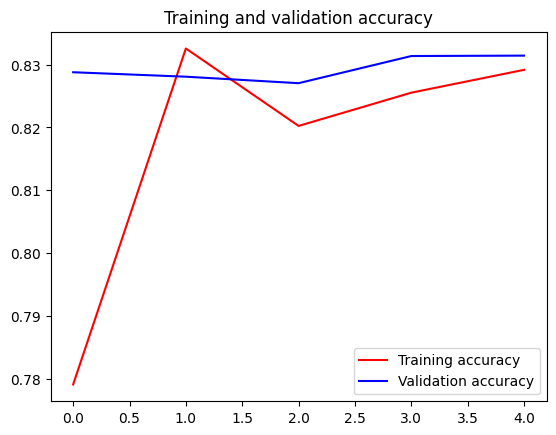

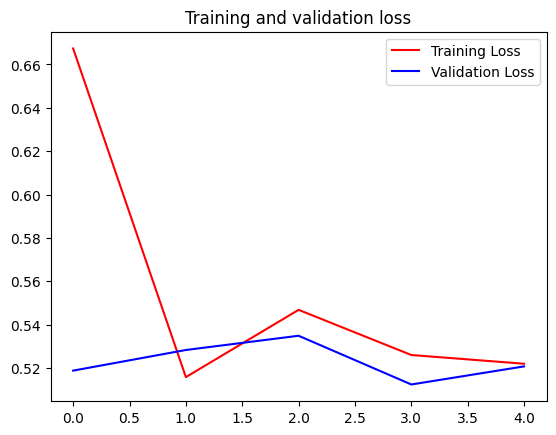

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Bi-LSTM Model**

In [ ]:
# Bidirectional LSTM

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 300, input_length=X_text_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 300)          20402700  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 512)         1140736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                      

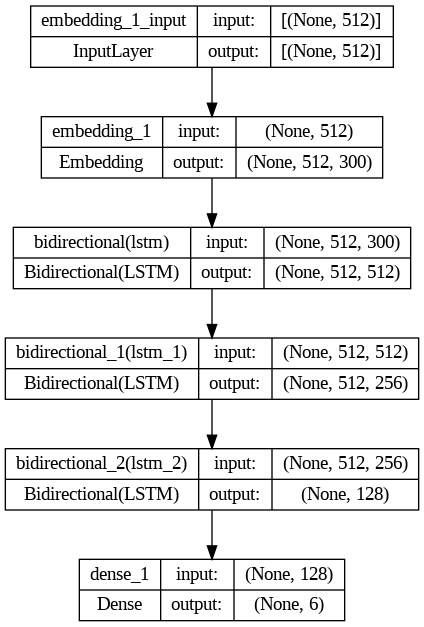

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_text_train,
                    y_train,
                    validation_data=(X_text_val, y_val),
                    verbose=1,
                    batch_size=64,
                    epochs=2,
                    callbacks=[callback]
                   )

Epoch 1/2
727/727 [==============================] - 6302s 9s/step - loss: 0.8679 - accuracy: 0.6988 - val_loss: 0.5847 - val_accuracy: 0.8138
Epoch 2/2
727/727 [==============================] - 6194s 9s/step - loss: 0.5664 - accuracy: 0.8198 - val_loss: 0.5399 - val_accuracy: 0.8266


In [ ]:
#print the overall loss and accuracy
model.evaluate(X_text_test, y_test, verbose=1)

485/485 [==============================] - 391s 807ms/step - loss: 0.5600 - accuracy: 0.8200


[0.5600059628486633, 0.8200064301490784]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have trained your model and have predictions
y_pred = model.predict(X_text_test)

# Assuming y_val and y_pred are in one-hot encoded format
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_test.argmax(axis=-1)

# Calculate overall precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-score:", f1)


485/485 [==============================] - 396s 813ms/step
Overall Precision: 0.8269613582093188
Overall Recall: 0.8200064536947402
Overall F1-score: 0.8208403848961435


In [ ]:
predicted = model.predict(X_text_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['subreddit']), y_pred))

485/485 [==============================] - 384s 791ms/step
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      4806
           1       0.81      0.79      0.80      2382
           2       0.92      0.72      0.81      1687
           3       0.74      0.77      0.76      2143
           4       0.74      0.72      0.73       805
           5       0.75      0.87      0.80      3672

    accuracy                           0.82     15495
   macro avg       0.81      0.79      0.80     15495
weighted avg       0.83      0.82      0.82     15495



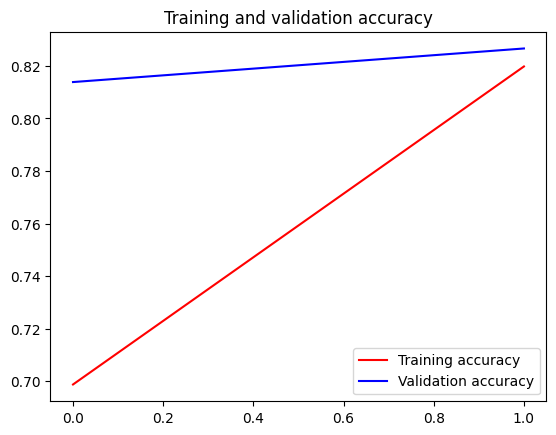

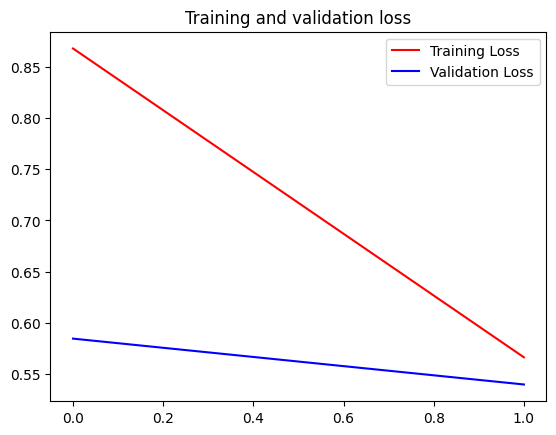

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Modelling with Text and Emoton Score features**

**GRU Model**

In [ ]:
#Using GRU Model

text_input = Input(shape=(X_text_train.shape[1],))
embedding_layer = Embedding(vocabSize, embedding_dim, input_length=X_text_train.shape[1], weights=[embedding_matrix], trainable=False)(text_input)

gru_1 = GRU(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)
gru_2 = GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(gru_1)
gru_3 = GRU(64, dropout=0.2, recurrent_dropout=0.2)(gru_2)

num_input = Input(shape=(X_num_train.shape[1],))
concatenated = Concatenate()([gru_3, num_input])

output = Dense(6, activation='softmax')(concatenated)

model = Model(inputs=[text_input, num_input], outputs=output)

adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 300)     20402700    ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      (None, 512, 256)     428544      ['embedding[0][0]']              
                                                                                                  
 gru_1 (GRU)                    (None, 512, 128)     148224      ['gru[0][0]']                    
                                                                                              

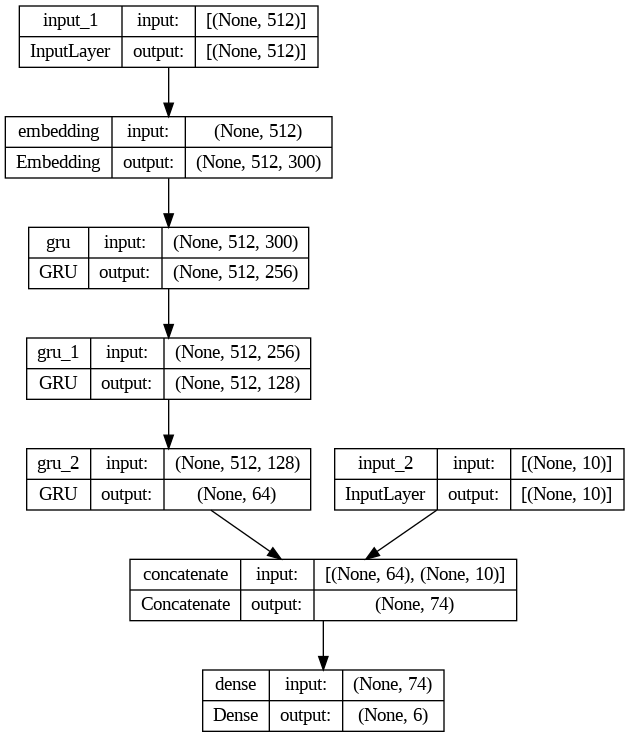

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(
    [X_text_train, X_num_train],
    y_train,
    validation_data=([X_text_val, X_num_val], y_val),
    verbose=1,
    batch_size=64,
    epochs=2,
    callbacks=[callback]
)

Epoch 1/2
727/727 [==============================] - 2948s 4s/step - loss: 0.7356 - accuracy: 0.7535 - val_loss: 0.5437 - val_accuracy: 0.8203
Epoch 2/2
727/727 [==============================] - 3056s 4s/step - loss: 0.5491 - accuracy: 0.8214 - val_loss: 0.5308 - val_accuracy: 0.8285


In [ ]:
#print the overall loss and accuracy
model.evaluate([X_text_test, X_num_test], y_test, verbose=1)

485/485 [==============================] - 190s 393ms/step - loss: 0.5605 - accuracy: 0.8190


[0.560496985912323, 0.8190383911132812]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have trained your model and have predictions
y_pred = model.predict([X_text_test, X_num_test])

# Assuming y_val and y_pred are in one-hot encoded format
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_test.argmax(axis=-1)

# Calculate overall precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-score:", f1)


485/485 [==============================] - 188s 385ms/step
Overall Precision: 0.8369504159039982
Overall Recall: 0.8190383994837044
Overall F1-score: 0.8186915394682681


In [ ]:
predicted = model.predict([X_text_test, X_num_test])
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['subreddit']), y_pred))

485/485 [==============================] - 188s 388ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4806
           1       0.83      0.77      0.80      2382
           2       0.86      0.76      0.81      1687
           3       0.92      0.63      0.75      2143
           4       0.82      0.69      0.75       805
           5       0.68      0.93      0.79      3672

    accuracy                           0.82     15495
   macro avg       0.84      0.78      0.80     15495
weighted avg       0.84      0.82      0.82     15495



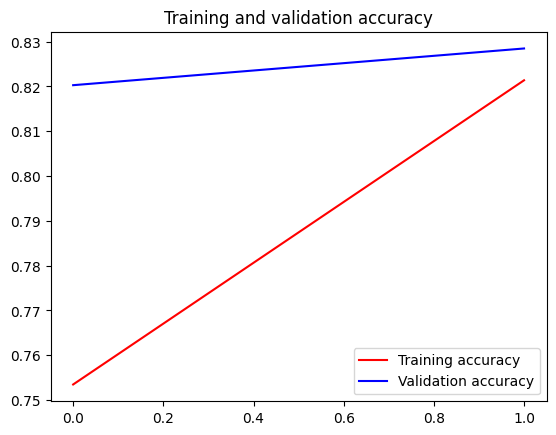

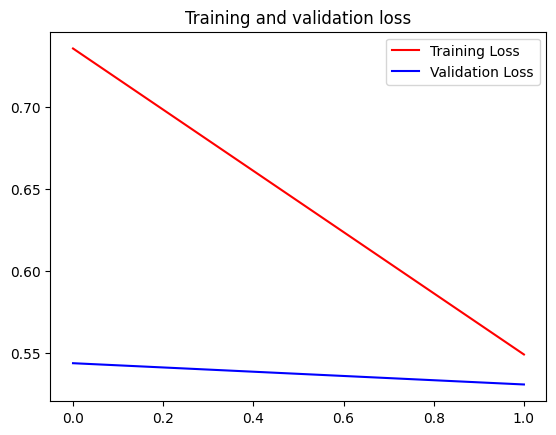

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Bi-LSTM Model**

In [ ]:
#BiDirectional LSTM

text_input = Input(shape=(X_text_train.shape[1],))
embedding_layer = Embedding(vocabSize, embedding_dim, input_length=X_text_train.shape[1], weights=[embedding_matrix], trainable=False)(text_input)

lstm_1 = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embedding_layer)
lstm_2 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(lstm_1)
lstm_3 = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(lstm_2)

num_input = Input(shape=(X_num_train.shape[1],))
concatenated = Concatenate()([lstm_3, num_input])

output = Dense(6, activation='softmax')(concatenated)

model = Model(inputs=[text_input, num_input], outputs=output)

adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 512, 300)     20402700    ['input_3[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 512, 512)     1140736     ['embedding_1[0][0]']            
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 512, 256)    656384      ['bidirectional[0][0]']          
 )                                                                                          

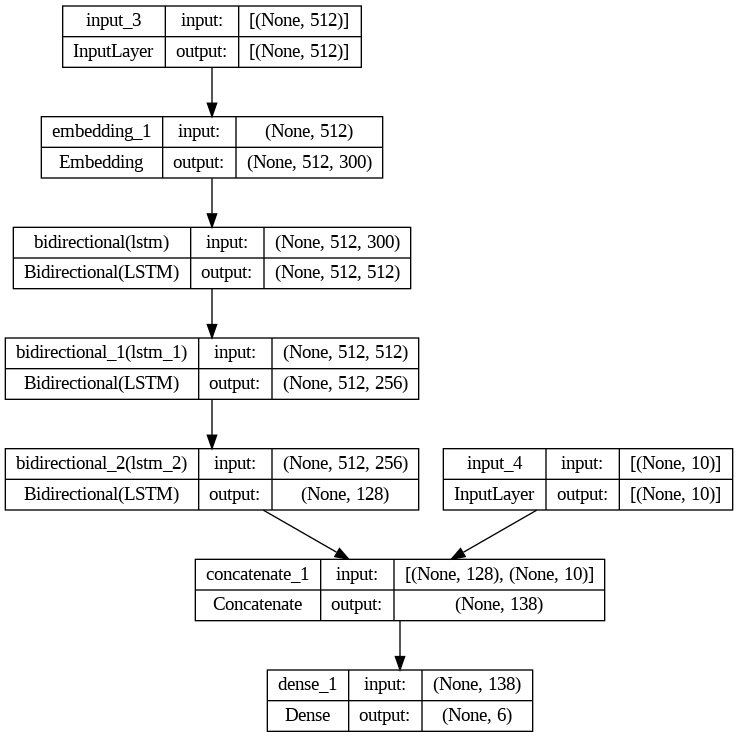

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [41]:
# Fit model
history = model.fit(
    [X_text_train, X_num_train],
    y_train,
    validation_data=([X_text_val, X_num_val], y_val),
    verbose=1,
    batch_size=64,
    epochs=2,
    callbacks=[callback]
)

Epoch 1/2
727/727 [==============================] - 6781s 9s/step - loss: 1.0597 - accuracy: 0.6088 - val_loss: 0.6618 - val_accuracy: 0.7861
Epoch 2/2
727/727 [==============================] - 6704s 9s/step - loss: 0.5848 - accuracy: 0.8104 - val_loss: 0.5424 - val_accuracy: 0.8212


In [42]:
#print the overall loss and accuracy
model.evaluate([X_text_test, X_num_test], y_test, verbose=1)

485/485 [==============================] - 409s 844ms/step - loss: 0.5645 - accuracy: 0.8152


[0.5644785165786743, 0.815166175365448]

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have trained your model and have predictions
y_pred = model.predict([X_text_test, X_num_test])

# Assuming y_val and y_pred are in one-hot encoded format
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_test.argmax(axis=-1)

# Calculate overall precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-score:", f1)


485/485 [==============================] - 410s 842ms/step
Overall Precision: 0.8276699952722987
Overall Recall: 0.8151661826395612
Overall F1-score: 0.816020436001321


In [44]:
predicted = model.predict([X_text_test, X_num_test])

y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['subreddit']), y_pred))

485/485 [==============================] - 405s 835ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4806
           1       0.89      0.70      0.78      2382
           2       0.86      0.78      0.82      1687
           3       0.82      0.73      0.78      2143
           4       0.74      0.73      0.74       805
           5       0.69      0.89      0.78      3672

    accuracy                           0.82     15495
   macro avg       0.82      0.79      0.80     15495
weighted avg       0.83      0.82      0.82     15495



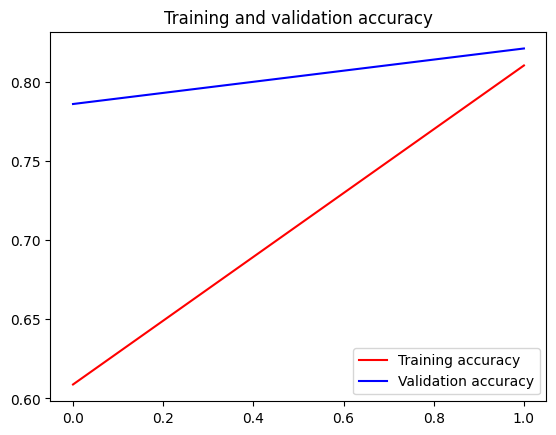

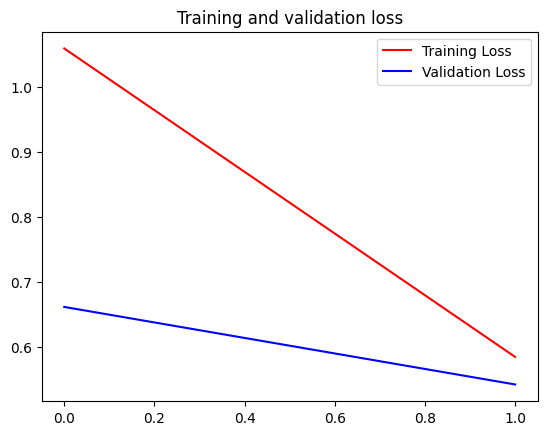

In [45]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **References**

https://www.kaggle.com/code/anubhavgoyal10/spam-classifier-nlp-98-accuracy

https://www.kaggle.com/code/maeshi/text-classification-with-neural-networks

https://www.kaggle.com/code/mohamedabdelmohsen/emotion-analysis-and-classification-using-lstm-93
